# Proyecto I: Reconocimiento Facial de Personas

En este proyecto vamos a desarrollar un sistema de reconocimiento de personas a travez de imagenes. El modelo desarrollado debe identificar al menos a 3 personas, y debe indicar si la persona esta sin tapabocas, con tapabocas o con el tapabocas mal puesto. Todas las demás personas para las cuales el modelo no haya sido entrenado deben identificarse como Persona desconocida, incluso personas que no se encuentren dentro del set de entrenamiento. A continuación se describe en detalle algunas consideraciones a tener en cuenta al desarrollar el modelo:

1. El modelo debe ser desarrollado utilizando redes convolucionales y se espera que se haga una evaluación exhaustiva del modelo. Es decir, se deben evaluar diferentes metricas de comportamiento del modelo, asi mismo como mostrar las matrices de confusión. Todas las metricas que utilicen deben ir acompañadas de los intervalos de confidencia. Deben evaluar al menos 4 arquitecturas diferentes, donde 3 de estas deben ser arquitecturas entrenadas desde 0, y la cuarta **puede** ser una arquitectura importada (transfer learning).

2. Además, aparte de realizar el test que siempre se hacer sobre el performance de la red (utilizando el set de prueba), deben probar la red al menos con un par de imagenes de las personas que debe reconocer pero que sean radicalmente diferentes a las imagenes que se usaron en entrenamiento, i.e. imagenes que ustedes crean sean dificiles para que la red las identifique de forma correcta.

3. Para este proyecto ustedes deben generar su propio dataset de entrenamiento. Para esto debe tener en cuenta que una red aprende de los ejemplos que se le presentan en el entrenamiento. Este proyecto deben entregarlo en un notebook de Jupyter, cada paso debe estar suficientemente descrito en el notebook, y se debe incluir un análisis exhaustivo de los resultados. A parte de esto deben contestar las siguientes preguntas:

     * ¿Qué criterio utilizarón para crear el dataset de entrenamiento y las imagenes de prueba que usaron en el punto 2?
     * ¿Son consistentes los resultados obtenidos, es lo que esperaban? Aqui es importante que relacionen arquitectura con resultados y que hagan un analisis del tamaño del modelo, hiperparametros, etc...
     * ¿Cómo pueden mejorar los resultados obtenidos?
     
En la entrega deben proporcionar todos los codigos, dentro del notebook, y la base de datos utilizada para entrenar. La fecha de entrega del proyecto es el **Jueves 17 de Marzo del 2022 a las 11:59 p.m**. Utilizando el link proporvcionado en el e-aulas. Mucha suerte!!!

### Introducción

En este notebook se presentan 4 modelos con diferentes arquitecturas. Cada uno de estos modelos ataca un mismo problema de clasificación de 10 clases donde se busca clasificar a 3 personas junto con el uso correcto, incorrecto y el no uso de tapabocas. Estas están dadas por

| Clase | Persona | Uso de mascarilla | 
| :---: | :---: | :---: |
| 0 | Camilo | con tapabocas |
| 1 | Camilo | sin tapabocas |
| 2 | Camilo | con tapabocas mal puesto |
| 3 | Kelly  | con tapabocas |
| 4 | Kelly  | sin tapabocas |
| 5 | Kelly  | con tapabocas mal puesto |
| 6 | Ana    | con tapabocas |
| 7 | Ana    | sin tapabocas |
| 8 | Ana    | con tapabocas mal puesto |
| 9 | Otra   | N.a |

### Desarrollo 

Para el desarrollo de este proyecto principalmente se hará uso de la librería tensorflow para la implementación de cada uno de los modelos y de la librería cv2 para el manejo de imágenes.

In [1]:
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import cross_val_score

import pandas as pd
import numpy as np
import cv2

import glob

from tabulate import tabulate
import seaborn as sns

import gradio as gr
import matplotlib.pyplot as plt
%matplotlib inline

Primero, se definen las siguientes funciones auxiliares que facilitan la implementación y entendimiento del código.

La función `increased_data` aumenta la cantidad de datos haciendo uso de técnicas de balanceo de datos, específicamente, se utilizan funciones de desenfoque y mejora de nitidez para un conjunto de imágenes.

In [2]:
def increased_data(images):
    new_images = []
    
    #Kernel to sharpen the image
    kernel = np.array([[-1,-1,-1],
                       [-1,9,-1],
                       [-1,-1,-1]])
    
    for img in images:
        new_images.append(img)
        
        img_blur = cv2.blur(img, (9,9))
        new_images.append(img_blur)
        
        img_gaussian = cv2.GaussianBlur(img, (9,9), 0)
        new_images.append(img_gaussian)
        
        img_sharpen = cv2.filter2D(img, -1, kernel)
        new_images.append(img_sharpen)
        
    return new_images

La función `normalitation`  como su nombre lo indica, realiza la normalizacion de cada imagen, este proceso se realiza separando cada capa de color de una imagen, se calcula la media y posteriormente se resta este valor a toda la capa de color.

In [3]:
def normalitation(imgs_with_mask, imgs_without_mask, imgs_mask_weared_incorrect, number_imgs):
    
    imgs_with_mask = np.divide(imgs_with_mask, 255)
    imgs_without_mask = np.divide(imgs_without_mask, 255)
    imgs_mask_weared_incorrect = np.divide(imgs_mask_weared_incorrect,255)

    for i in range(number_imgs):
        img = imgs_with_mask[i]
        mean_r = np.mean(img[:,:,0])
        mean_g = np.mean(img[:,:,1])
        mean_b = np.mean(img[:,:,2])
        mean_img = [mean_r, mean_g, mean_b]
        imgs_with_mask[i] = np.subtract(imgs_with_mask[i], mean_img)


        img1 = imgs_without_mask[i]
        mean1_r = np.mean(img1[:,:,0])
        mean1_g = np.mean(img1[:,:,1])
        mean1_b = np.mean(img1[:,:,2])
        mean1_img = [mean1_r, mean1_g, mean1_b]
        imgs_without_mask[i] = np.subtract(imgs_without_mask[i], mean1_img)

        img2 = imgs_mask_weared_incorrect[i]
        mean2_r = np.mean(img2[:,:,0])
        mean2_g = np.mean(img2[:,:,1])
        mean2_b = np.mean(img2[:,:,2])
        mean2_img = [mean2_r, mean2_g, mean2_b]
        imgs_mask_weared_incorrect[i] = np.subtract(imgs_mask_weared_incorrect[i], mean2_img)
    return imgs_with_mask, imgs_without_mask, imgs_mask_weared_incorrect

La función `acc_loss_plot` realiza el plot de epoch vs loss y de epoch vs Accuracy.

In [4]:
def acc_loss_plot(history):
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    
    plt.show()

La función `heat_map` realiza la grafica de la matriz de confusión.

In [5]:
def heat_map(test, predict):
    y_pred = [np.argmax(predict[i], axis=0) for i in range(len(predict))]
    y_test = [int(test[i][0]) for i in range(len(test))]
    
    confussion_matrix_net = metrics.confusion_matrix(y_test, y_pred)
    class_names=[i for i in range(10)]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    sns.heatmap(pd.DataFrame(confussion_matrix_net), cmap='viridis', annot=True,fmt='g')
    plt.title('Mapa de calor', y=1.1)
    plt.ylabel('True Label')
    plt.xlabel('Predic Label')

La función `model_metrics` crea una tabla compuesta de las principales métricas de un modelo (precisión, sensibilidad, f1, número de ocurrencias) donde se puede evaluar el rendimiento del mismo.

In [6]:
'''Se tiene que verificar la forma en la cual se pasa test y predict dado que son multiclase'''

def model_metrics(test, predict):
    
    y_pred = [np.argmax(predict[i], axis=0) for i in range(len(predict))]
    y_test = [int(test[i][0]) for i in range(len(test))]
    
    precision_net, recall_net, fscore_net, support_net = metrics.precision_recall_fscore_support(y_test, y_pred)
    num_class = precision_net.shape[0]
    info = []
    for i in range(num_class):
        metrics_class_i = [i, precision_net[i], recall_net[i], fscore_net[i], support_net[i]]
        info.append(metrics_class_i)
    print(tabulate(info, headers=["Clase", "Precision", "Sensitivity", "F1 Score", "number of occurrences"]))

### Carga de datos

Para la construcción del conjunto de datos se consideró el uso de 15 imágenes por clase. Para todas las imágenes cargadas se realiza un redimensionamiento a un tamaño de (250,250) y también un escalamiento, de forma que los valores de los píxeles se encuentren en un rango de [0,1]. Luego de cargar los datos, se hace un incremento de datos con la función definida anteriormente `increased_data` y posteriormente se normalizan.

In [7]:
dim = (250, 250)
number_imgs = 15

In [8]:
p1_with_mask = glob.glob('Personas/Camilo/with_mask/*')
p1_without_mask = glob.glob('Personas/Camilo/without_mask/*')
p1_mask_weared_incorrect = glob.glob('Personas/Camilo/mask_weared_incorrect/*')

p1_imgs_with = [cv2.resize(cv2.imread(i), dim, interpolation=cv2.INTER_LANCZOS4)
                for i in p1_with_mask[:number_imgs]]
p1_imgs_without = [cv2.resize(cv2.imread(i), dim, interpolation=cv2.INTER_LANCZOS4)
                   for i in p1_without_mask[:number_imgs]]
p1_imgs_weared_incorrect = [cv2.resize(cv2.imread(i), dim, interpolation=cv2.INTER_LANCZOS4)
                            for i in p1_mask_weared_incorrect[:number_imgs]]

p1_imgs_with = increased_data(p1_imgs_with)
p1_imgs_without = increased_data(p1_imgs_without)
p1_imgs_weared_incorrect = increased_data(p1_imgs_weared_incorrect)

p1_imgs_w, p1_imgs_w_out, p1_imgs_incorrect = normalitation(p1_imgs_with,
                                                            p1_imgs_without,
                                                            p1_imgs_weared_incorrect,
                                                            number_imgs)

In [9]:
p2_with_mask = glob.glob('Personas/Kelly/with_mask/*')
p2_without_mask = glob.glob('Personas/Kelly/without_mask/*')
p2_mask_weared_incorrect = glob.glob('Personas/Kelly/mask_weared_incorrect/*')


p2_imgs_with = [cv2.resize(cv2.imread(i), dim, interpolation=cv2.INTER_LANCZOS4)
                for i in p2_with_mask[:number_imgs]]
p2_imgs_without = [cv2.resize(cv2.imread(i), dim, interpolation=cv2.INTER_LANCZOS4)
                   for i in p2_without_mask[:number_imgs]]
p2_imgs_weared_incorrect = [cv2.resize(cv2.imread(i), dim, interpolation=cv2.INTER_LANCZOS4)
                            for i in p2_mask_weared_incorrect[:number_imgs]]

p2_imgs_with = increased_data(p2_imgs_with)
p2_imgs_without = increased_data(p2_imgs_without)
p2_imgs_weared_incorrect = increased_data(p2_imgs_weared_incorrect)

p2_imgs_w, p2_imgs_w_out, p2_imgs_incorrect = normalitation(p2_imgs_with,
                                                            p2_imgs_without,
                                                            p2_imgs_weared_incorrect,
                                                            number_imgs)

In [10]:
p3_with_mask = glob.glob('Personas/Ana/with_mask/*')
p3_without_mask = glob.glob('Personas/Ana/without_mask/*')
p3_mask_weared_incorrect = glob.glob('Personas/Ana/mask_weared_incorrect/*')


p3_imgs_with = [cv2.resize(cv2.imread(i), dim, interpolation=cv2.INTER_LANCZOS4)
                for i in p3_with_mask[:number_imgs]]
p3_imgs_without = [cv2.resize(cv2.imread(i), dim, interpolation=cv2.INTER_LANCZOS4)
                   for i in p3_without_mask[:number_imgs]]
p3_imgs_weared_incorrect = [cv2.resize(cv2.imread(i), dim, interpolation=cv2.INTER_LANCZOS4)
                            for i in p3_mask_weared_incorrect[:number_imgs]]

p3_imgs_with = increased_data(p3_imgs_with)
p3_imgs_without = increased_data(p3_imgs_without)
p3_imgs_weared_incorrect = increased_data(p3_imgs_weared_incorrect)

p3_imgs_w, p3_imgs_w_out, p3_imgs_incorrect = normalitation(p3_imgs_with,
                                                            p3_imgs_without,
                                                            p3_imgs_weared_incorrect,
                                                            number_imgs)

In [11]:
others_p = glob.glob('Personas/otros/*')

others_img = [cv2.resize(cv2.imread(i), dim, interpolation=cv2.INTER_LANCZOS4)
                for i in others_p[:number_imgs]]

others_img = increased_data(others_img)

others_p_imgs, _, _ = normalitation(others_img, others_img, others_img, number_imgs)

### Creación del dataset

Una vez cargadas todas las imágenes se define el dataset concatenando todas las clases cargadas y creamos las respectivas etiquetas.


In [12]:
X = np.concatenate((p1_imgs_w, p1_imgs_w_out, p1_imgs_incorrect,
                    p2_imgs_w, p2_imgs_w_out, p2_imgs_incorrect,
                    p3_imgs_w, p3_imgs_w_out, p3_imgs_incorrect,
                    others_p_imgs))

len_label = np.ones((len(p1_imgs_w),1))

p1_label_with_mask = len_label*0
p1_label_without_mask = len_label*1
p1_label_incorrect = len_label*2

p2_label_with_mask = len_label*3
p2_label_without_mask = len_label*4
p2_label_incorrect = len_label*5

p3_label_with_mask = len_label*6
p3_label_without_mask = len_label*7
p3_label_incorrect = len_label*8

other_label = len_label*9

y = np.concatenate((p1_label_with_mask, p1_label_without_mask, p1_label_incorrect,
                    p2_label_with_mask, p2_label_without_mask, p2_label_incorrect,
                    p3_label_with_mask, p3_label_without_mask, p3_label_incorrect,
                    other_label))

Se dividen los datos en los conjuntos de prueba, entrenamiento y validación. Note que el conjunto de entrenamiento y validación  está compuesto por el 70% de las imágenes.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Dada la baja cantidad de observaciones, definimos un modelo auxiliar para aumentar la diversidad del conjunto de entrenamiento y validación. Este modelo está compuesto por 3 capas de preprocesamiento. La primera invierte aleatoriamente las imágenes, la segunda las gira aleatoriamente y la tercera ajusta aleatoriamente el contraste.


In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(factor=0.2),
    tf.keras.layers.RandomContrast(0.5)
])

Estas capas de preprocesamiento se añaden a cada uno de los modelos definidos a continuación.

## Primer modelo

In [15]:
model_1 = tf.keras.Sequential()

model_1.add(data_augmentation)

#Layer
model_1.add(tf.keras.layers.Conv2D(
    filters= 32, kernel_size=(5,5), strides=(1,1),
    padding='same', data_format='channels_last', 
    name='Convolution_layer_1', activation='relu'))

#Add Max pooling layer
model_1.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_layer_1'))

#Add convolutional layer    
model_1.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='Convolution_layer_2', activation='relu'))

model_1.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_layer_2'))

#Add Flatten Layer
model_1.add(tf.keras.layers.Flatten())

#Add the Fully COnnected network
model_1.add(tf.keras.layers.Dense(
    units=1024, name='Fully_Connected_layer_1', 
    activation='relu'))

model_1.add(tf.keras.layers.Dropout(
    rate=0.5))
    
model_1.add(tf.keras.layers.Dense(
    units=10, name='Fully_Connected_layer_2',
    activation='softmax'))

#The input shape
model_1.build(input_shape=(None, dim[0], dim[1], 3))
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 250, 250, 3)       0         
                                                                 
 Convolution_layer_1 (Conv2D  (None, 250, 250, 32)     2432      
 )                                                               
                                                                 
 pool_layer_1 (MaxPooling2D)  (None, 125, 125, 32)     0         
                                                                 
 Convolution_layer_2 (Conv2D  (None, 125, 125, 64)     51264     
 )                                                               
                                                                 
 pool_layer_2 (MaxPooling2D)  (None, 62, 62, 64)       0         
                                                                 
 flatten (Flatten)           (None, 246016)           

In [16]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(), loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
#train the model
history_1 = model_1.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=15, shuffle=True)

Epoch 1/15
10/10 [==============================] - 37s 4s/step - loss: 8.7160 - accuracy: 0.1016 - val_loss: 2.3274 - val_accuracy: 0.0857
Epoch 2/15
10/10 [==============================] - 27s 3s/step - loss: 2.2819 - accuracy: 0.1270 - val_loss: 2.2865 - val_accuracy: 0.1333
Epoch 3/15
10/10 [==============================] - 28s 3s/step - loss: 2.2011 - accuracy: 0.1778 - val_loss: 2.2661 - val_accuracy: 0.1238
Epoch 4/15
10/10 [==============================] - 26s 3s/step - loss: 2.0227 - accuracy: 0.2635 - val_loss: 2.1748 - val_accuracy: 0.2000
Epoch 5/15
10/10 [==============================] - 27s 3s/step - loss: 1.9910 - accuracy: 0.2921 - val_loss: 1.9063 - val_accuracy: 0.2857
Epoch 6/15
10/10 [==============================] - 27s 3s/step - loss: 1.8618 - accuracy: 0.3206 - val_loss: 1.8838 - val_accuracy: 0.2476
Epoch 7/15
10/10 [==============================] - 27s 3s/step - loss: 1.7569 - accuracy: 0.3683 - val_loss: 1.6659 - val_accuracy: 0.3429
Epoch 8/15
10/10 [==

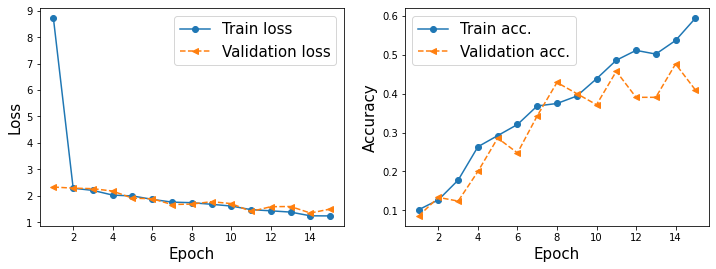

In [18]:
acc_loss_plot(history_1)

Fijándonos en la gráfica de costo vs épocas (loss vs epoch) podemos observar que la red puede ser más compleja dado que no está presente una brecha entre el conjunto de validación y entrenamiento. También, podemos observar que en la época 14 comienza a generarse esta brecha, observando simultáneamente la gráfica de  accuracy vs épocas podemos ver que la red aun tiene la capacidad de aprender por lo cual la red debería ser entrenada para una mayor cantidad de épocas. 

In [19]:
test_results = model_1.evaluate(X_test, y_test)
print('\nTest loss. {:.2f}'.format(test_results[0]))
print('Test Acc. {:.2f}%'.format(test_results[1]*100))

6/6 [==============================] - 3s 450ms/step - loss: 1.5812 - accuracy: 0.4778

Test loss. 1.58
Test Acc. 47.78%


Podemos ver que el accuracy aún tiene un valor muy bajo por lo cual el modelo no puede realizar una buena clasificación. 

In [23]:
y1_pred = model_1.predict(X_test)

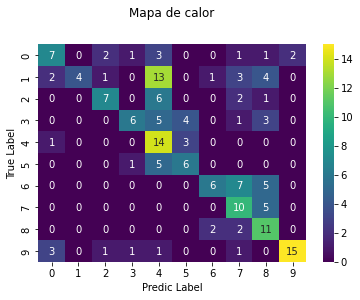

In [24]:
heat_map(y_test, y1_pred)

Observando la matriz de confusión podemos ver que las clases mejor clasificadas son las clases 4 y 9 que corresponden a: Kelly sin tapabocas y Otra persona (persona desconocida) podemos observar también que  la clase en la cual se presenta una mayor cantidad de falsos positivos es la clase 1 en la cual se ha clasificado como Camilo sin tapabocas cuando realmente pertenece a la clase Kelly sin tapabocas

In [25]:
model_metrics(y_test, y1_pred)

  Clase    Precision    Sensitivity    F1 Score    number of occurrences
-------  -----------  -------------  ----------  -----------------------
      0     0.538462       0.411765    0.466667                       17
      1     1              0.142857    0.25                           28
      2     0.636364       0.4375      0.518519                       16
      3     0.666667       0.315789    0.428571                       19
      4     0.297872       0.777778    0.430769                       18
      5     0.461538       0.5         0.48                           12
      6     0.666667       0.333333    0.444444                       18
      7     0.37037        0.666667    0.47619                        15
      8     0.366667       0.733333    0.488889                       15
      9     0.882353       0.681818    0.769231                       22


En la tabla podemos confirmar las observaciones sobre la matriz de confusión. Podemos decir que la clase 4 es la que mayor sensitividad tiene. También, podemos ver que la clase 9 es la que mayor precisión tiene. Adicional a ello podemos ver que esta clase también tiene el mayor valor “F1 Score” el cual da un balance entre la sensitividad y la precisión atendiendo a que en este grupo es donde hay menor cantidad de FN (Falsos negativos), FP (Falsos positivos) y TN (verdaderos negratios).

# Segundo modelo

In [26]:
model_2 = tf.keras.Sequential()

model_2.add(data_augmentation)

#Layer
model_2.add(tf.keras.layers.Conv2D(
    filters= 100, kernel_size=(3,3), strides=(1,1),
    kernel_initializer = tf.keras.initializers.HeNormal(),
    padding='same', data_format='channels_last', 
    name='Convolution_layer_1', activation='relu'))

model_2.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2,2), name='MaxPooling_1'))

model_2.add(tf.keras.layers.Conv2D(
    filters = 100, kernel_size= (3,3), strides=(1,1),
    kernel_initializer= tf.keras.initializers.HeNormal(),
    padding='same', data_format='channels_last',
    name='Convolution_layer_2', activation='relu'))

model_2.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2,2), name='MaxPooling_2'))

model_2.add(tf.keras.layers.Flatten())

model_2.add(tf.keras.layers.Dropout(rate=0.5))

model_2.add(tf.keras.layers.Dense(
    units=50, name='Dense_layer_1',activation='relu'))

model_2.add(tf.keras.layers.Dense(
    units=10, name='Dense_layer_2', activation='softmax'))

#The input shape
model_2.build(input_shape=(None, 250, 250, 3))
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 250, 250, 3)       0         
                                                                 
 Convolution_layer_1 (Conv2D  (None, 250, 250, 100)    2800      
 )                                                               
                                                                 
 MaxPooling_1 (MaxPooling2D)  (None, 125, 125, 100)    0         
                                                                 
 Convolution_layer_2 (Conv2D  (None, 125, 125, 100)    90100     
 )                                                               
                                                                 
 MaxPooling_2 (MaxPooling2D)  (None, 62, 62, 100)      0         
                                                                 
 flatten_1 (Flatten)         (None, 384400)           

In [27]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(), loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [28]:
#train the model
history_2 = model_2.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=10, shuffle=True)

Epoch 1/10
10/10 [==============================] - 28s 3s/step - loss: 10.6852 - accuracy: 0.1492 - val_loss: 2.2914 - val_accuracy: 0.2000
Epoch 2/10
10/10 [==============================] - 28s 3s/step - loss: 2.2265 - accuracy: 0.1937 - val_loss: 2.4963 - val_accuracy: 0.1714
Epoch 3/10
10/10 [==============================] - 29s 3s/step - loss: 2.1058 - accuracy: 0.2349 - val_loss: 2.2217 - val_accuracy: 0.2190
Epoch 4/10
10/10 [==============================] - 29s 3s/step - loss: 1.9914 - accuracy: 0.3143 - val_loss: 2.1970 - val_accuracy: 0.2476
Epoch 5/10
10/10 [==============================] - 29s 3s/step - loss: 1.8913 - accuracy: 0.3397 - val_loss: 2.1143 - val_accuracy: 0.3333
Epoch 6/10
10/10 [==============================] - 29s 3s/step - loss: 1.7578 - accuracy: 0.4222 - val_loss: 1.9609 - val_accuracy: 0.3524
Epoch 7/10
10/10 [==============================] - 30s 3s/step - loss: 1.6175 - accuracy: 0.4730 - val_loss: 1.6757 - val_accuracy: 0.4286
Epoch 8/10
10/10 [=

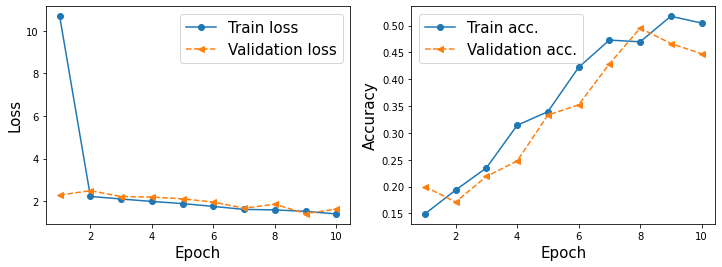

In [29]:
acc_loss_plot(history_2)

Podemos ver que este modelo, a pesar de ser mucho más pequeño que el anterior dado que se tiene una cantidad considerablemente menor de parámetros a entrenar, se obtienen resultados similares. Podemos ver que de igual forma la brecha entre las épocas y la función de costo es mínima y de igual forma el accuracy frente a las épocas mejora, por lo cual, esta arquitectura puede ser mucho más compleja o ser entrenada por una mayor cantidad de épocas para obtener mejores resultados. Cabe destacar que este modelo fue entrenado en una menor cantidad de épocas.

In [30]:
test_results = model_2.evaluate(X_test, y_test)
print('\nTest loss. {:.2f}'.format(test_results[0]))
print('Test Acc. {:.2f}%'.format(test_results[1]*100))

6/6 [==============================] - 4s 663ms/step - loss: 1.7885 - accuracy: 0.4778

Test loss. 1.79
Test Acc. 47.78%


Podemos ver que, el accuracy de esta arquitectura es igual al anterior aunque el costo es mayor por 0.21

In [31]:
y2_pred = model_2.predict(X_test)

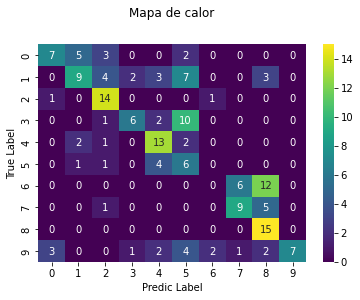

In [32]:
heat_map(y_test, y2_pred)

Analizando la matriz de confusión, vemos que las clases con una mayor cantidad de verdaderos positivos son las clases 2 y 8 que corresponden respectivamente a Camilo con tapabocas mal puesto y Ana con tapabocas mal puesto.

In [33]:
model_metrics(y_test, y2_pred)

  Clase    Precision    Sensitivity    F1 Score    number of occurrences
-------  -----------  -------------  ----------  -----------------------
      0     0.636364       0.411765    0.5                            17
      1     0.529412       0.321429    0.4                            28
      2     0.56           0.875       0.682927                       16
      3     0.666667       0.315789    0.428571                       19
      4     0.541667       0.722222    0.619048                       18
      5     0.193548       0.5         0.27907                        12
      6     0              0           0                              18
      7     0.5625         0.6         0.580645                       15
      8     0.405405       1           0.576923                       15
      9     1              0.318182    0.482759                       22


Podemos ver que la clase con mejor puntaje en “F1 Score” es la clase 2. por otro lado es importante observar y resaltar que las clases 8 y 9 presentan un valor de 1 para la sensitividad y precisión respectivamente en vista de que, en estas clases no se presentó verdaderos negativos.

# Tercer modelo

In [57]:
model_3 = tf.keras.Sequential()

model_3.add(data_augmentation)

model_3.add(tf.keras.layers.Conv2D(
    filters=16, kernel_size=(3,3), strides=(1,1),
    kernel_initializer=tf.keras.initializers.HeNormal(),
    padding='same', data_format='channels_last',
    name='Convolution_layer_1', activation='relu'))

model_3.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2,2), name='MaxPooling_1'))

model_3.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(3,3), strides=(1,1),
    kernel_initializer=tf.keras.initializers.HeNormal(),
    padding='same', data_format='channels_last',
    name='Convolution_layer_2', activation='relu'))

model_3.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2,2), name='MaxPooling_2'))

model_3.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3,3), strides=(1,1),
    kernel_initializer=tf.keras.initializers.HeNormal(),
    padding='same', data_format='channels_last',
    name='Convolution_layer_3', activation='relu'))

model_3.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2,2), name='MaxPooling_3'))

model_3.add(tf.keras.layers.Conv2D(
    filters=128, kernel_size=(3,3), strides=(1,1),
    kernel_initializer=tf.keras.initializers.HeNormal(),
    padding='same', data_format='channels_last',
    name='Convolution_layer_4', activation='relu'))

model_3.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2,2), name='MaxPooling_4'))

model_3.add(tf.keras.layers.Conv2D(
    filters=256, kernel_size=(3,3), strides=(1,1),
    kernel_initializer=tf.keras.initializers.HeNormal(),
    padding='same', data_format='channels_last',
    name='Convolution_layer_5', activation='relu'))

model_3.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2,2), name='MaxPooling_5'))

model_3.add(tf.keras.layers.Flatten())

model_3.add(tf.keras.layers.Dropout(rate=0.5))

model_3.add(tf.keras.layers.Dense(
    units=50, name='Dense_layer_1',activation='relu'))

model_3.add(tf.keras.layers.Dense(
    units=10, name='Dense_layer_2', activation='softmax'))

#The input shape
model_3.build(input_shape=(None, 250, 250, 3))
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 250, 250, 3)       0         
                                                                 
 Convolution_layer_1 (Conv2D  (None, 250, 250, 16)     448       
 )                                                               
                                                                 
 MaxPooling_1 (MaxPooling2D)  (None, 125, 125, 16)     0         
                                                                 
 Convolution_layer_2 (Conv2D  (None, 125, 125, 32)     4640      
 )                                                               
                                                                 
 MaxPooling_2 (MaxPooling2D)  (None, 62, 62, 32)       0         
                                                                 
 Convolution_layer_3 (Conv2D  (None, 62, 62, 64)      

In [58]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(), loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [59]:
#train the model
history_3 = model_3.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=25, shuffle=True)

Epoch 1/25
10/10 [==============================] - 8s 759ms/step - loss: 2.7004 - accuracy: 0.1492 - val_loss: 2.3349 - val_accuracy: 0.0952
Epoch 2/25
10/10 [==============================] - 8s 772ms/step - loss: 2.2207 - accuracy: 0.1556 - val_loss: 2.3570 - val_accuracy: 0.2095
Epoch 3/25
10/10 [==============================] - 8s 840ms/step - loss: 2.1190 - accuracy: 0.1968 - val_loss: 2.1711 - val_accuracy: 0.1524
Epoch 4/25
10/10 [==============================] - 8s 792ms/step - loss: 1.9404 - accuracy: 0.2825 - val_loss: 2.0635 - val_accuracy: 0.2476
Epoch 5/25
10/10 [==============================] - 8s 812ms/step - loss: 1.8059 - accuracy: 0.3524 - val_loss: 1.8163 - val_accuracy: 0.3810
Epoch 6/25
10/10 [==============================] - 8s 832ms/step - loss: 1.6162 - accuracy: 0.4063 - val_loss: 1.6927 - val_accuracy: 0.3619
Epoch 7/25
10/10 [==============================] - 8s 807ms/step - loss: 1.4510 - accuracy: 0.4571 - val_loss: 1.5355 - val_accuracy: 0.3333
Epoch 

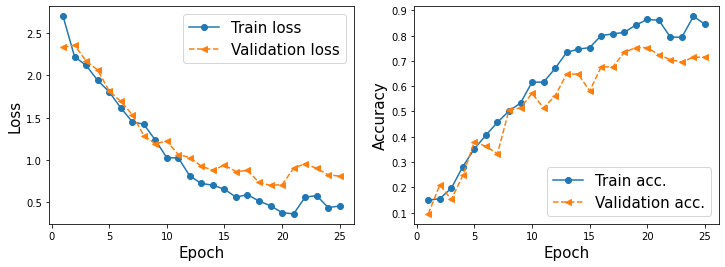

In [60]:
acc_loss_plot(history_3)

Teniendo en cuenta los modelos anteriores, este es el modelo con la menor cantidad de parámetros totales pero así mismo es el modelo con la mayor cantidad de neuronas, dadas estas características y los recursos computacionales disponibles, podemos realizar un entrenamiento con una mayor cantidad de épocas. Observamos que el comportamiento del costo en función de las épocas, se puede percatar la brecha que se mantiene desde la época 15 aproximadamente, pero podemos ver también que esta no tiene un aumento frente a las épocas anteriores, por lo cual no se puede afirmar con certeza la existencia de sobreajuste.

In [61]:
test_results = model_3.evaluate(X_test, y_test)
print('\nTest loss. {:.2f}'.format(test_results[0]))
print('Test Acc. {:.2f}%'.format(test_results[1]*100))

6/6 [==============================] - 1s 181ms/step - loss: 0.7944 - accuracy: 0.7333

Test loss. 0.79
Test Acc. 73.33%


Note que este modelo ya presenta un accuracy más aceptable y en comparativa a los anteriores modelos, tiene un buen accuracy, de igual forma, observando el costo vemos que este es menor a 1.

In [62]:
y3_pred = model_3.predict(X_test)

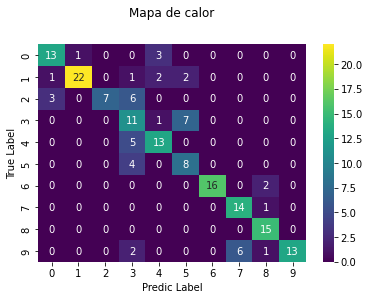

In [63]:
heat_map(y_test, y3_pred)

Analizando la matriz de confusión, podemos notar que, dado que el modelo presenta un accuracy “bueno” la mayoría de las clases presenta una buena cantidad de verdaderos positivos.

In [64]:
model_metrics(y_test, y3_pred)

  Clase    Precision    Sensitivity    F1 Score    number of occurrences
-------  -----------  -------------  ----------  -----------------------
      0     0.764706       0.764706    0.764706                       17
      1     0.956522       0.785714    0.862745                       28
      2     1              0.4375      0.608696                       16
      3     0.37931        0.578947    0.458333                       19
      4     0.684211       0.722222    0.702703                       18
      5     0.470588       0.666667    0.551724                       12
      6     1              0.888889    0.941176                       18
      7     0.7            0.933333    0.8                            15
      8     0.789474       1           0.882353                       15
      9     1              0.590909    0.742857                       22


Observando las diferentes métricas, podemos ver que, para la precisión, exceptuando dos valores (clase 3 y 5) todos los demás están por encima de 0.6. Adicional a ello, las clases 2, 6 y 9 que corresponden a Camilo con tapabocas mal puesto, Ana con tapabocas y Otros (persona desconocida) respectivamente tienen un valor de 1. Observando ahora la sensitividad, podemos notar que todos los valores exceptuando 1 (clase 2) son mayores a 0.5. Ahora bien, la clase con mayor valor para “F1 Score” es la clase 6 (Ana con tapabocas). Analizando esta clase (6), podemos inferir que estos resultados se deben a la similaridad de las fotos con las cuales fue creado el dataset.

# Cuarto modelo

Este modelo hace uso de una arquitectura importada. La arquitectura a usar es ResNet50, la cual es una red convolucional de 50 capas de profundidad que fue pre estrenada con más de un millón de imágenes del dataset `ImageNet` las cuales fueron clasificadas en 1000 categorías.

Para cumplir con el fin de nuestro proyecto, se adaptó la arquitectura de ResNet50 para que reciba imágenes de tamaño (250,250,3), adicionalmente se definen 2 capas de pre entrenamiento para hacer un aumento de datos donde se invierte y rota aleatoriamente las imágenes. Dado que este modelo implementa una arquitectura pre entrenada, no se hace el uso de las 3 capas de aumento de datos definidas para los modelos anteriores. 

Por último, es importante resaltar que los valores de los parámetros de la red ResNet50 no son alterados y solamente se entrenan los pesos de las últimas capas 

In [43]:
model_4_base = tf.keras.applications.ResNet50(
    weights="imagenet", 
    input_shape = (dim[0], dim[1], 3),
    include_top=False,
)

model_4_base.trainable = False

inputs = tf.keras.Input(shape = (dim[0], dim[1], 3))

data_augmentation = tf.keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal"),
     tf.keras.layers.RandomRotation(0.1),]
)

x = data_augmentation(inputs)

x = tf.keras.applications.resnet.preprocess_input(x)

x = model_4_base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout

outputs = tf.keras.layers.Dense(10)(x)
model_4 = tf.keras.Model(inputs, outputs)

model_4.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 250, 250, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 250, 250, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 250, 250, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [44]:
model_4.compile(optimizer=tf.keras.optimizers.Adam(), loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [45]:
history_4 = model_4.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10, shuffle=True)

Epoch 1/10
10/10 [==============================] - 30s 3s/step - loss: 7.9464 - accuracy: 0.1079 - val_loss: 6.4388 - val_accuracy: 0.0667
Epoch 2/10
10/10 [==============================] - 27s 3s/step - loss: 6.9943 - accuracy: 0.0825 - val_loss: 6.3935 - val_accuracy: 0.0667
Epoch 3/10
10/10 [==============================] - 27s 3s/step - loss: 6.6994 - accuracy: 0.1016 - val_loss: 6.3972 - val_accuracy: 0.0762
Epoch 4/10
10/10 [==============================] - 30s 3s/step - loss: 6.6560 - accuracy: 0.0921 - val_loss: 6.3976 - val_accuracy: 0.0762
Epoch 5/10
10/10 [==============================] - 31s 3s/step - loss: 6.6500 - accuracy: 0.0984 - val_loss: 6.3976 - val_accuracy: 0.0762
Epoch 6/10
10/10 [==============================] - 28s 3s/step - loss: 6.6479 - accuracy: 0.1175 - val_loss: 6.3976 - val_accuracy: 0.0571
Epoch 7/10
10/10 [==============================] - 28s 3s/step - loss: 6.6513 - accuracy: 0.1048 - val_loss: 6.3976 - val_accuracy: 0.0667
Epoch 8/10
10/10 [==

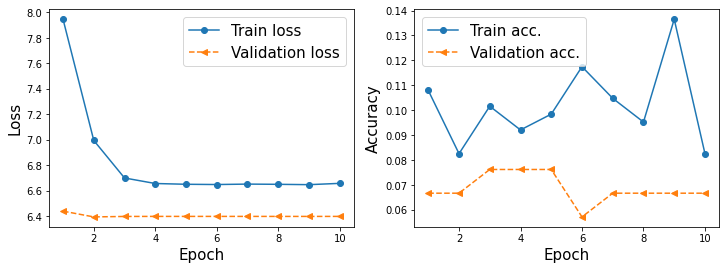

In [46]:
acc_loss_plot(history_4)

Podemos observar que el valor de costo y accuracy para el conjunto de validación se estanca en un cierto intervalo de épocas.

In [47]:
test_results = model_4.evaluate(X_test, y_test)
print('\nTest loss. {:.2f}'.format(test_results[0]))
print('Test Acc. {:.2f}%'.format(test_results[1]*100))

6/6 [==============================] - 12s 2s/step - loss: 7.2291 - accuracy: 0.1222

Test loss. 7.23
Test Acc. 12.22%


Podemos ver que el modelo presenta el menor de los accuracy en comparativa a los modelos anteriores y de igual forma, presenta el mayor valor de costo.

In [48]:
y4_pred = model_4.predict(X_test)

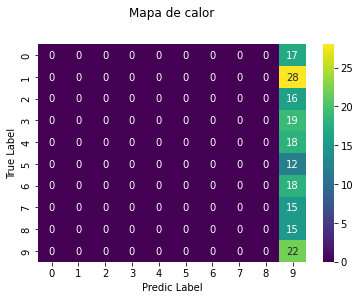

In [49]:
heat_map(y_test, y4_pred)

Note que, el modelo presenta fallas al momento de clasificar ya que, como se observa, todas las imágenes son clasificadas como otros (persona desconocida)

In [50]:
model_metrics(y_test, y4_pred)

  Clase    Precision    Sensitivity    F1 Score    number of occurrences
-------  -----------  -------------  ----------  -----------------------
      0     0                     0    0                              17
      1     0                     0    0                              28
      2     0                     0    0                              16
      3     0                     0    0                              19
      4     0                     0    0                              18
      5     0                     0    0                              12
      6     0                     0    0                              18
      7     0                     0    0                              15
      8     0                     0    0                              15
      9     0.122222              1    0.217822                       22


C:\Users\camil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dada la clasificación que genera el modelo, la única clase con valores distintos de 0 es la clase 9

## Gui de prueba

In [51]:
def choose_model(model_name, img):
    models = {'Modelo 1': model_1,
              'Modelo 2': model_2,
              'Modelo 3': model_3,
              'Modelo 4': model_4}
    
    model = models[model_name]
    
    mean_r = np.mean(img[:,:,0])
    mean_g = np.mean(img[:,:,1])
    mean_b = np.mean(img[:,:,2])
    mean_img = [mean_r, mean_g, mean_b]
    img_norm = np.subtract(img, mean_img)
    
    pred = model.predict(img_norm)
    
    #Idk if there is something
    return pred

In [56]:
iface = gr.Interface(
    fn = choose_model,
    inputs = [gr.inputs.Radio(['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4']),
              gr.inputs.Image()],
    outputs = gr.outputs.Label(num_top_classes=3)
)

iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861/
Running on public URL: https://41659.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x1e31f11d8c8>,
 'http://127.0.0.1:7861/',
 'https://41659.gradio.app')

### Conclusiones

* El criterio de creación del dataset y el uso de imágenes fue limitado por la capacidad computacional disponible ya que se tenía un limitado espacio de almacenamiento y uso de memoria RAM, de igual forma, esta limitación influye directamente en la cantidad de épocas de entrenamiento y en la definición de cada arquitectura. 
* Los resultados obtenidos en cada modelo exceptuando el cuarto, son consistentes con los datos presentados, ya que, dada la cantidad de estos, los modelos desempeñan un buen rendimiento.
* El uso de técnicas de aumento de datos y balanceo puede ayudar a solventar las pocas imágenes recolectadas para el entrenamiento y prueba de los modelos
* La normalización de los datos junto con las técnicas de inicialización de parámetros ayudan a que, con pocas épocas, los modelos presentan buenos resultados .
* En los primeros 2 modelos se podría observar una mejora en los resultados si se utilizara una mayor cantidad de épocas.
* Dados los datos y la similaridad entre las imágenes de cada clase, se condiciona el resultado de cada una de las clases. Como ejemplo de esto, se tiene la clase 6 donde la variación de las imágenes es poca por lo cual los modelos clasifican de mejor manera en este tipo de clases.
